### Stack overflow

* <b> pyspark remove special characters in all column names for all special characters </b>
<code>
    import re
    df = df.select([F.col(col).alias(re.sub("[^0-9a-zA-Z$]+","",i)) for col in df.columns])
</code>    

* <b> How is the string column in DataFrame split into multiple columns when Spark Structed Streaming </b>
    <code>
        from pyspark.sql.functions import *

        lines.withColumn("tmp",split(col("value"),',')).\
        withColumn("col1",col("tmp")[0]).\
        withColumn("col2",col("tmp").getItem(1)).\
        withColumn("col3",element_at(col("tmp"),3))
        drop("tmp","value").\
        show()


        import pyspark.sql.functions as F

        max_size = df.select(F.max(F.length(F.regexp_replace('value','[^,]','')))).first()[0]
        out = df.select([F.split("value",',')[x].alias(f"Col{x+1}") for x in range(max_size+1)])
    </code>    

* <b> How to remove the empty columns from dataframe of pyspark </b>
<code>
    cols = df.columns
    list_of_empty_cols = []
    for col_name in cols:
        list_of_empty_cols =
        if df.filter(df(col_name).isNotNull).count() == 0:
             list_of_empty_cols.append(col_name)
             
    df = df.drop(*list_of_empty_cols)
</code>    

* <b> Spark Repartition Executors </b>

    You can use repartition along with partitionBy to resolve the issue. There are two ways to solve this.

    Suppose you need to partition by dateColumn

    <code>
        df.repartition(5, 'dateColumn').write.partitionBy('dateColumn').parquet(path)
    </code>  

   In this case the number of executors used will be equal to 5 * distinct(dateColumn) and all your date will contain 5 files each.

   Another approach is to repartition your data 3 times no of executors then using maxRecordsPerFile to save data this will create equal sizze files but you will lose control over the number of files created

    <code>
        df.repartition(60).write.option('maxRecordsPerFile',200000).partitionBy('dateColumn').parquet(path)
    </code>  

* <b> How to control output file size and no of files? </b>

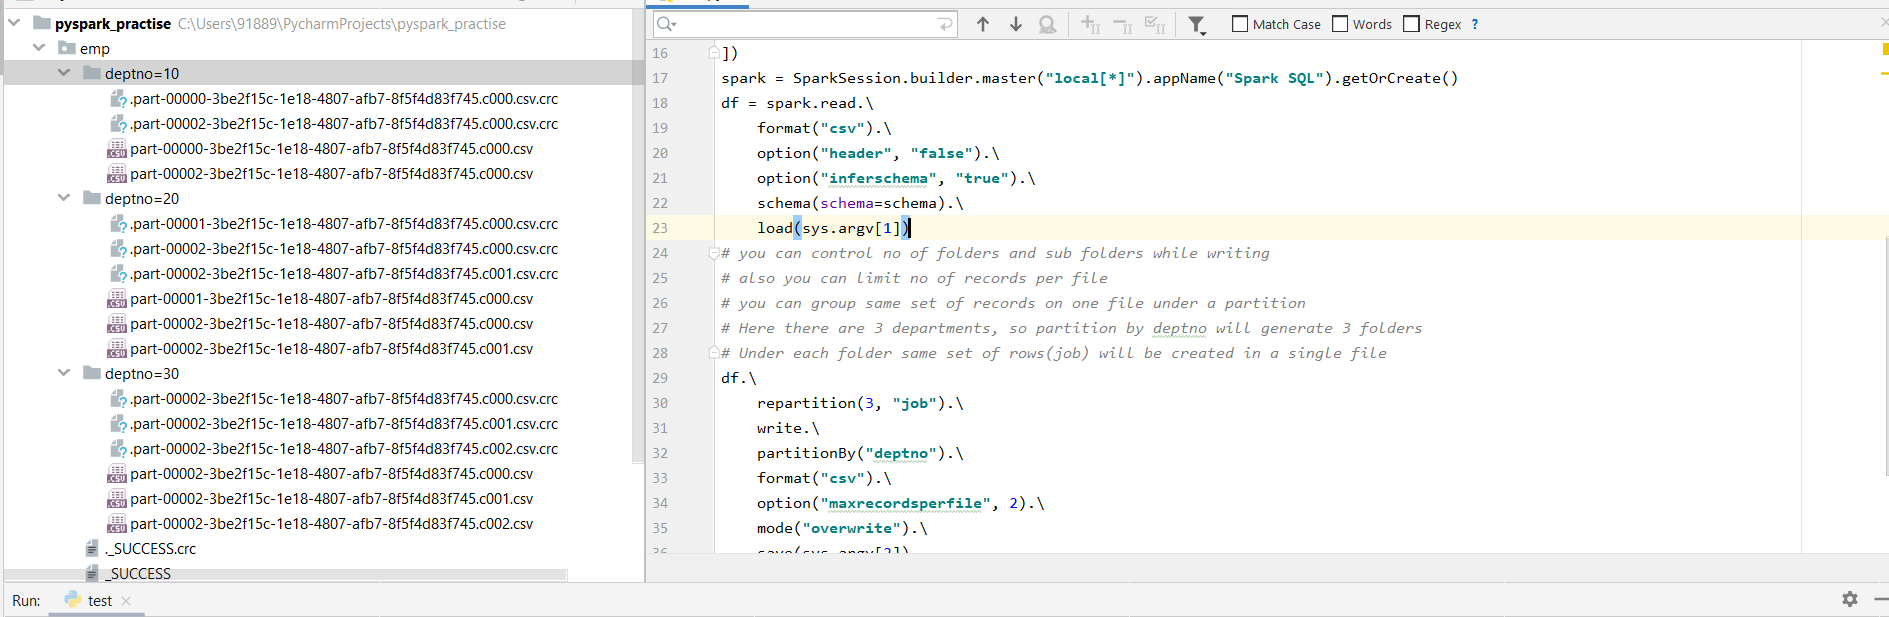

* <b> Best method to save intermediate tables in pyspark </b>
     
     My purpose is to save numerous Pyspark dataframes in some format so that they can be re-used in a separate Pyspark session. I have thought of 2 options:

        1 Save dataframes as hive tables.
        2 Save them as parquet files.
    
    The best option is to use parquet files as they have following advantages:

        * 3x compressed saves space
        * Columnar format, faster pushdowns
        * Optimized with spark catalyst optimizer
        * Schema persists as parquet contains schema related info.
    
    The only issue is make sure you are not generating multiple small files, the default parquet block size is 128 mb so make sure you have files sufficiently large. You can repartition the data to make sure the file size is large enough

* <b> when do you get java heap space error? </b>
     
    when you perform collect on large dataset, driver will collect all the data and it's larger than driver memory, so you get this error session will stop/ job will fail
    
    To avoid use
    <code> 
    spark.sparkContext.set('spark.driver.memory','6000M')
    </code>


Spark submit tuning:

https://spoddutur.github.io/spark-notes/distribution_of_executors_cores_and_memory_for_spark_application.html?fbclid=IwAR3xiFLBXBkwX2SrcJFZU0tfHU7Gssp-NJstfLDSRSRZzJgK6ybvJjSVcpY

* <b> the difference between “one Executor per Core vs one Executor with multiple Core” </b>
     
    1 executor with 16 core means you will have 1 JVM which can run maximum of 16 tasks

    16 executor with 1 CORE means you will have 16 JVM and each JVM can run one task.
    
    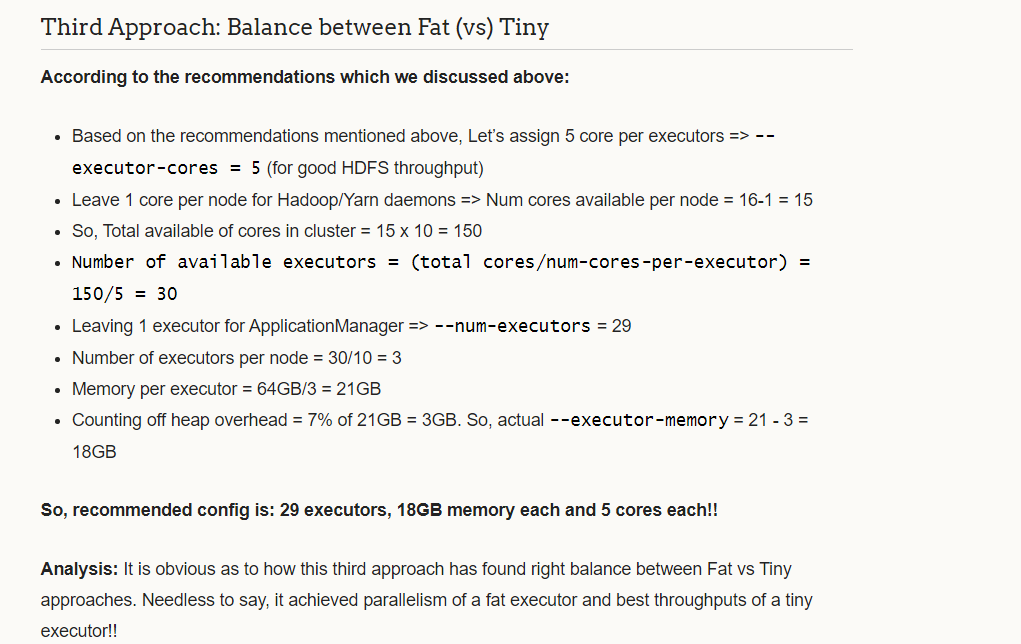

* <b> How to check if a Hive table exists using PySpark? </b>
     
   <code>   pyspark.sql.catalog </code> module is included from spark >= 2.3.0


* <b> What are Dataframe reader modes? </b>
     
    * PERMISSIVE            
            If any of the field(consider EMP.COMM) value doesn't match with defined schema, then enrite row will be blank for that field
        
    * DROPMALFORMED
            If any of the field(EMP.COMM is a float) not match with defined schema Integer, then entire column will be blank
    
    * FAILFAST
            if any of the field data type doesn't match defined schema then error will throw and session stops


* <b> How to remove the double quote when the value is empty in Spark?? </b>
     
<code>
    myDF.coalesce(1).write\
    .option("emptyValue", None)\
    .option("nullValue", None)\
    .csv(outFile)
</code>

* <b> How to speed up spark df.write jdbc to postgres database? </b>
     
    Repartition your dataframe dynamically based on number of rows in df
    <code> 
    df.repartition(10).write.option("maxRecordsPerFile", 100000).mode("overwrite").csv("path/to/save/data)
    </code>

    Now read the files using python and execute copy command for each file.


   <code>
    import psycopg2    

    iterate over your files here and generate file object you can also get files list using os module

    file = open('path/to/save/data/part-00000_0.csv')
    file1 = open('path/to/save/data/part-00000_1.csv')

    define a function
    def execute_copy(fileName):
        con = psycopg2.connect(database=dbname,user=user,password=password,host=host,port=port)
        cursor = con.cursor()
        cursor.copy_from(fileName, 'table_name', sep=",")
        con.commit()
        con.close()
   </code>